# Snakes and Ladders

In [52]:
import sys
sys.path.append('../')

from dataclasses import dataclass
from typing import Mapping, Tuple, Dict
from rl.distribution import Categorical
from rl.markov_process import Transition, FiniteMarkovProcess, FiniteMarkovRewardProcess

import numpy as np
import seaborn as sns

# Problem 2

In [73]:
@dataclass(frozen=True)
class BoardPositionState:
    # check that at most one of the above is true
    state_num: int
    
    
class SnakesLaddersMPFinite(FiniteMarkovProcess[BoardPositionState]):
    
    def __init__(
        self,
        snake_ladder_states,
    ):
        self.snl_states: Mapping[int, int] = snake_ladder_states
        self.near_end_states: set() = {95, 96, 97, 99}
        
        super().__init__(self.get_transition_map())
    
    def endprobs(self, state_num) -> Mapping[BoardPositionState, float]:
        """Convert from a state near the end to a transition probability"""
        state_probs_map: Mapping[BoardPositionState, float] = {}
        probs_map: Mapping[int, float] = {}
            
        for k in range(1,7):
            if k <= (100 - state_num):
                nextstate = state_num + k
                if nextstate not in probs_map:
                    probs_map[nextstate] = 1.0/6.0
                else:
                    probs_map[nextstate] += 1.0/6.0
            else:
                nextstate = 100 - (state_num + k - 100)
                if nextstate not in probs_map:
                    probs_map[nextstate] = 1.0/6.0
                else:
                    probs_map[nextstate] += 1.0/6.0
        #print(state_num, probs_map)
        for state in probs_map.keys():
            state_probs_map[BoardPositionState(state)] = probs_map[state]
            
        return state_probs_map
    
    def get_transition_map(self) -> Transition[BoardPositionState]:
        d: Dict[BoardPositionState, Categorical[BoardPositionState]] = {}
        
        # iterate over the normal states to construct their probabilities
        for statenum in range(0, 100):
            snl = statenum in self.snl_states
            near_end = statenum in self.near_end_states
            state = BoardPositionState(statenum)
                
            # is this a special state?
            if snl:
                realstatenum = self.snl_states[statenum]
            else:
                realstatenum = statenum
            
            # is this a normal state?
            if not near_end:
                # use real state number to determine probs
                state_probs_map: Mapping[BoardPositionState, float] = {
                    BoardPositionState(realstatenum + k): 1.0/6.0 for k in range(1,7)
                }
            else:
                state_probs_map: Mapping[BoardPositionState, float] = \
                    self.endprobs(realstatenum)
            d[BoardPositionState(statenum)] = Categorical(state_probs_map)
        
        # Winning Absorbing State
        d[BoardPositionState(100)] = None
        return d            

In [74]:
snl_states = {98: 54, 94: 42, 82: 63, 88: 50, 76: 37, 70:34, 65:14, 53:17, 49: 8, 38:1,
              3: 39, 7:48, 12:51, 20:41, 25:57, 28:35, 45:74, 60:85, 67:90, 69:92}
snl_mp = SnakesLaddersMPFinite(snl_states)
#print(snl_mp)
# print("Transition Map")
# print("--------------")
# print(snl_mp)

# Starting Distribution
start_dist_map: Mapping[BoardPositionState, float] = {
                    BoardPositionState(k): 1.0/6.0 for k in range(1,7)
                }
start_dist = Categorical(start_dist_map)

In [75]:
# simple path tracing example
tracer = snl_mp.traces(start_dist)
path = []
sim = next(tracer)
nextstate = BoardPositionState(0)
while True:
    try:
        nextstate = next(sim)
        path.append(next(sim))
    except StopIteration:
        break
print(path)

[BoardPositionState(state_num=11), BoardPositionState(state_num=19), BoardPositionState(state_num=46), BoardPositionState(state_num=49), BoardPositionState(state_num=57), BoardPositionState(state_num=90), BoardPositionState(state_num=100)]


In [76]:
# creating a prob dist of finishing steps
pathlengths = []
tracer = snl_mp.traces(start_dist)

for i in range(1000):
    pathlen = 0
    sim = next(tracer)
    nextstate = BoardPositionState(0)
    while True:
        try:
            nextstate = next(sim)
            pathlen += 1
        except StopIteration:
            break
    pathlengths.append(pathlen)

/Users/bodhinguyen/Code/RL-book/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


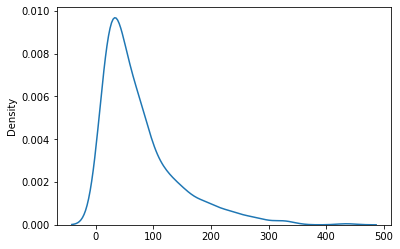

In [77]:
# Distribution of finishing times
sns.distplot(pathlengths, hist = False, kde = True)

In [78]:
# average finishing time and median
print(np.mean(pathlengths))
print(np.median(pathlengths))

76.42
55.0


# Problem 4

In [79]:
class SnakesLaddersMRPFinite(FiniteMarkovRewardProcess[BoardPositionState]):
    
    def __init__(
        self,
        snake_ladder_states,
    ):
        self.snl_states: Mapping[int, int] = snake_ladder_states
        self.near_end_states: set() = {95, 96, 97, 99}
        
        super().__init__(self.get_transition_reward_map())
    
    def endprobs(self, state_num) -> Mapping[BoardPositionState, float]:
        """Convert from a state near the end to a transition probability"""
        state_probs_map: Mapping[BoardPositionState, float] = {}
        probs_map: Mapping[int, float] = {}
            
        for k in range(1,7):
            if k <= (100 - state_num):
                nextstate = state_num + k
                if nextstate not in probs_map:
                    probs_map[nextstate] = 1.0/6.0
                else:
                    probs_map[nextstate] += 1.0/6.0
            else:
                nextstate = 100 - (state_num + k - 100)
                if nextstate not in probs_map:
                    probs_map[nextstate] = 1.0/6.0
                else:
                    probs_map[nextstate] += 1.0/6.0
        #print(state_num, probs_map)
        for state in probs_map.keys():
            state_probs_map[(BoardPositionState(state), 1)] = probs_map[state]
            
        return state_probs_map
    
    def get_transition_reward_map(self) -> Transition[BoardPositionState]:
        d: Dict[BoardPositionState, Categorical[Tuple[BoardPositionState, float]]] = {}
        
        # iterate over the normal states to construct their probabilities
        for statenum in range(0, 100):
            snl = statenum in self.snl_states
            near_end = statenum in self.near_end_states
            state = BoardPositionState(statenum)
                
            # is this a special state?
            if snl:
                realstatenum = self.snl_states[statenum]
            else:
                realstatenum = statenum
            
            # is this a normal state?
            if not near_end:
                # use real state number to determine probs
                # use reward of 1 in each state
                state_probs_map: Dict[Tuple[BoardPositionState, float], float] = {
                    (BoardPositionState(realstatenum + k), 1): 1.0/6.0 for k in range(1,7)
                }
            else:
                state_probs_map: Dict[Tuple[BoardPositionState, float], float] = \
                    self.endprobs(realstatenum)
            d[BoardPositionState(statenum)] = Categorical(state_probs_map)
        
        # Winning Absorbing State
        d[BoardPositionState(100)] = None
        return d            

In [80]:
snl_mrp = SnakesLaddersMRPFinite(snl_states)
#print(snl_mrp)

In [81]:
# simple path tracing example
tracer = snl_mrp.traces(start_dist)
path = []
sim = next(tracer)
nextstate = BoardPositionState(0)
while True:
    try:
        nextstate = next(sim)
        path.append(next(sim))
    except StopIteration:
        break
print(path)

[BoardPositionState(state_num=10), BoardPositionState(state_num=16), BoardPositionState(state_num=24), BoardPositionState(state_num=34), BoardPositionState(state_num=41), BoardPositionState(state_num=47), BoardPositionState(state_num=50), BoardPositionState(state_num=57), BoardPositionState(state_num=89), BoardPositionState(state_num=93), BoardPositionState(state_num=99), BoardPositionState(state_num=99), BoardPositionState(state_num=97), BoardPositionState(state_num=97), BoardPositionState(state_num=100)]


In [82]:
print("Value of State 0: Expected Number of Rolls")
print("--------------")
snl_mrp.get_value_function_vec(gamma= 1.0)[0]

Value of State 0: Expected Number of Rolls
--------------


73.62067827061108